# Suvendu Bista  
**Course:** Advanced Big Data and Data Mining (MSCS-634-B01)  
**📊 Project Deliverable 2: Regression Modeling and Performance Evaluation**


In [47]:
# ----------------------------------------
# Loading cleaned dataset (csv)
# ----------------------------------------

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score, mean_squared_error

# Load cleaned dataset
df = pd.read_csv('/Users/suvendubista/Downloads/cleaned_world_bank_data_2025.csv')
print("Data loaded successfully")

Data loaded successfully


In [48]:
# ----------------------------------------
# Performing feature engineering
# ----------------------------------------

import pandas as pd
import numpy as np


# 1. Create GDP per Capita Growth Rate feature
df['GDP_per_Capita_Growth'] = df.groupby('country_name')['GDP per Capita (Current USD)'].pct_change() * 100

# 2. Create Inflation Difference feature (CPI vs GDP Deflator)
df['Inflation_Diff'] = df['Inflation (CPI %)'] - df['Inflation (GDP Deflator, %)']

# 3. Create Government Efficiency Ratio
df['Govt_Efficiency'] = df['Tax Revenue (% of GDP)'] / df['Government Expense (% of GDP)']

# 4. Create Economic Health Index (composite metric)
df['Economic_Health'] = (
    df['GDP Growth (% Annual)'] + 
    (1 / df['Unemployment Rate (%)']) - 
    df['Inflation (CPI %)']
)

# 5. Log-transform skewed features
df['Log_GDP'] = np.log1p(df['GDP (Current USD)'])
df['Log_GDP_per_Capita'] = np.log1p(df['GDP per Capita (Current USD)'])

# ----------------------------------------
# Clean and handle NaNs and infinite values
# ----------------------------------------

# Replace infinite values with NaN (due to division by zero or log issues)
df.replace([np.inf, -np.inf], np.nan, inplace=True)

# Fill missing values in numeric columns with the median of each column
df.fillna(df.select_dtypes(include='number').median(), inplace=True)

print("✅ Feature engineering completed.")


✅ Feature engineering completed.


In [27]:
# ----------------------------------------
# Preparing data for modelling
# ----------------------------------------


# Select target variable (GDP per Capita)
target = 'GDP per Capita (Current USD)'
y = df[target]

# Select features (excluding identifiers and raw GDP columns)
features = [
    'year', 'Inflation (CPI %)', 'Unemployment Rate (%)', 
    'Interest Rate (Real, %)', 'GDP Growth (% Annual)',
    'Current Account Balance (% GDP)', 'Government Expense (% of GDP)',
    'Tax Revenue (% of GDP)', 'Public Debt (% of GDP)',
    'GDP_per_Capita_Growth', 'Inflation_Diff', 'Govt_Efficiency',
    'Economic_Health', 'Log_GDP'
]
X = df[features]

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# Scale features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print(f"Data prepared: {X_train.shape[0]} training samples, {X_test.shape[0]} test samples")

Data prepared: 2777 training samples, 695 test samples


In [49]:
# ----------------------------------------
#  Building Regression Models
# ----------------------------------------

import warnings
from sklearn.exceptions import ConvergenceWarning
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import cross_val_score
from sklearn.metrics import r2_score, mean_squared_error
import numpy as np

# Optional: suppress convergence warnings for cleaner output
warnings.filterwarnings("ignore", category=ConvergenceWarning)

# Initialize Regression Models with tuned Lasso parameters
models = {
    'Linear Regression': LinearRegression(),
    'Ridge Regression': Ridge(alpha=1.0),
    'Lasso Regression': Lasso(alpha=0.1, max_iter=30000),  # Increased max_iter for convergence
    'Random Forest': RandomForestRegressor(n_estimators=100, random_state=42)
}

# Dictionary to store results
results = {}

# Train and Evaluate Each Model
for name, model in models.items():
    # Train model
    model.fit(X_train_scaled, y_train)
    
    # Predict on test data
    y_pred = model.predict(X_test_scaled)
    
    # Calculate evaluation metrics
    r2 = r2_score(y_test, y_pred)
    mse = mean_squared_error(y_test, y_pred)
    rmse = np.sqrt(mse)
    
    # 5-fold cross-validation on training data
    cv_scores = cross_val_score(model, X_train_scaled, y_train, cv=5, scoring='r2')
    cv_mean = cv_scores.mean()
    
    # Save results
    results[name] = {
        'R2': r2,
        'MSE': mse,
        'RMSE': rmse,
        'CV R2 Mean': cv_mean,
        'CV R2 Std': cv_scores.std(),
        'Model': model
    }
    
    print(f"{name} trained and evaluated ✅")



Linear Regression trained and evaluated ✅
Ridge Regression trained and evaluated ✅
Lasso Regression trained and evaluated ✅
Random Forest trained and evaluated ✅


Model Performance Comparison:
               Model        R2           MSE          RMSE  CV R2 Mean  \
3      Random Forest  0.824799  9.115436e+07   9547.479303    0.839547   
0  Linear Regression  0.215537  4.081432e+08  20202.554082    0.255009   
2   Lasso Regression  0.215526  4.081492e+08  20202.701842    0.255013   
1   Ridge Regression  0.213356  4.092780e+08  20230.620066    0.254079   

   CV R2 Std  
3   0.017199  
0   0.021230  
2   0.021233  
1   0.021860  


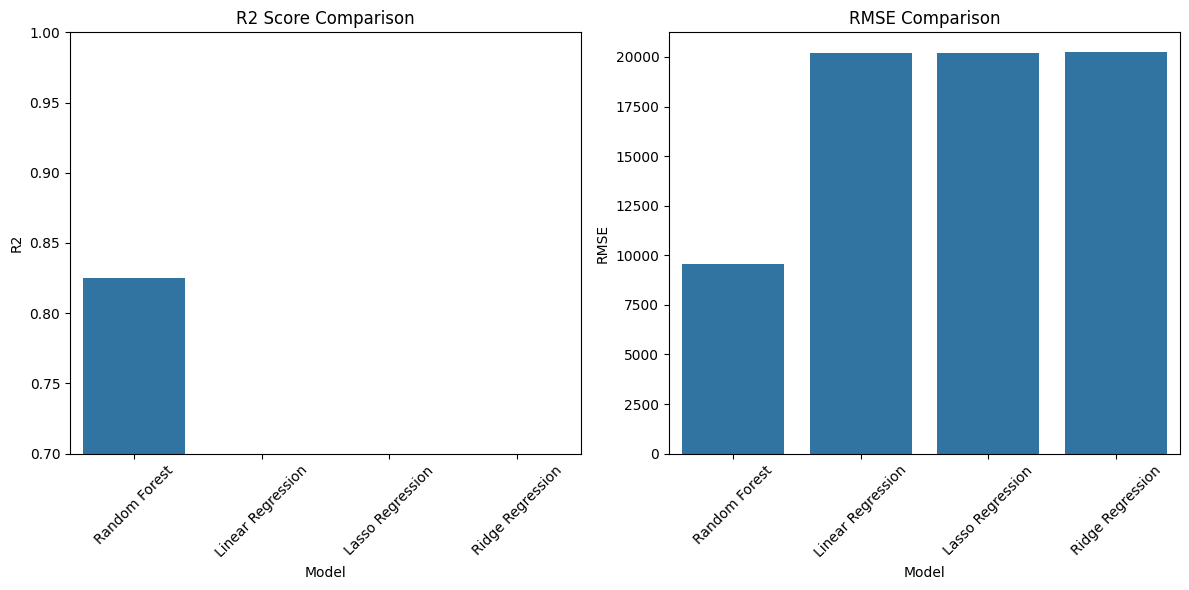

In [50]:
# ----------------------------------------
#  Evaluating Model Performance
# ----------------------------------------

# Compare model metrics
metrics_df = pd.DataFrame({
    'Model': results.keys(),
    'R2': [res['R2'] for res in results.values()],
    'MSE': [res['MSE'] for res in results.values()],
    'RMSE': [res['RMSE'] for res in results.values()],
    'CV R2 Mean': [res['CV R2 Mean'] for res in results.values()],
    'CV R2 Std': [res['CV R2 Std'] for res in results.values()]
}).sort_values(by='R2', ascending=False)

print("Model Performance Comparison:")
print(metrics_df)

# Visualize model performance
plt.figure(figsize=(12, 6))

# R2 Comparison
plt.subplot(1, 2, 1)
sns.barplot(x='Model', y='R2', data=metrics_df)
plt.title('R2 Score Comparison')
plt.xticks(rotation=45)
plt.ylim(0.7, 1.0)

# RMSE Comparison
plt.subplot(1, 2, 2)
sns.barplot(x='Model', y='RMSE', data=metrics_df)
plt.title('RMSE Comparison')
plt.xticks(rotation=45)

plt.tight_layout()
plt.savefig('model_performance_comparison.png')
plt.show()

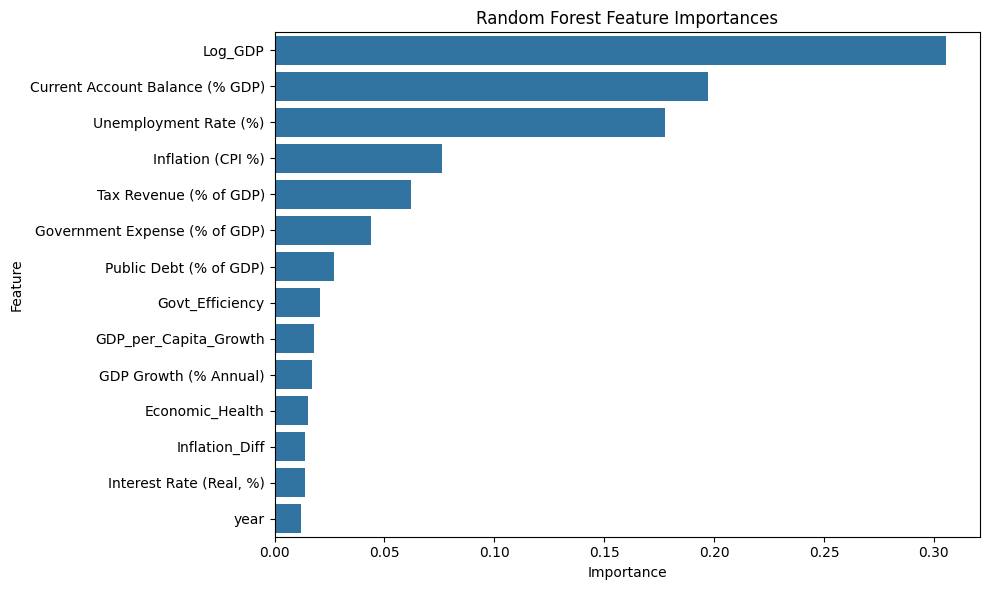

Top 5 Features:
                            Feature  Importance
13                          Log_GDP    0.305688
5   Current Account Balance (% GDP)    0.197224
2             Unemployment Rate (%)    0.177716
1                 Inflation (CPI %)    0.076136
7            Tax Revenue (% of GDP)    0.062029


In [40]:
# ----------------------------------------
#  Feature Importance Analysis
# ----------------------------------------

# Get best model (Random Forest)
best_model = results['Random Forest']['Model']

# Extract feature importances
importances = best_model.feature_importances_
feature_importance = pd.DataFrame({
    'Feature': features,
    'Importance': importances
}).sort_values(by='Importance', ascending=False)

# Plot feature importances
plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=feature_importance)
plt.title('Random Forest Feature Importances')
plt.tight_layout()
plt.savefig('feature_importances.png')
plt.show()

print("Top 5 Features:")
print(feature_importance.head(5))


Best Performing Model: Random Forest
R2 Score: 0.8248
RMSE: $9,547.48 (per capita)

Top Predictive Features:
- Log_GDP
- Current Account Balance (% GDP)
- Unemployment Rate (%)


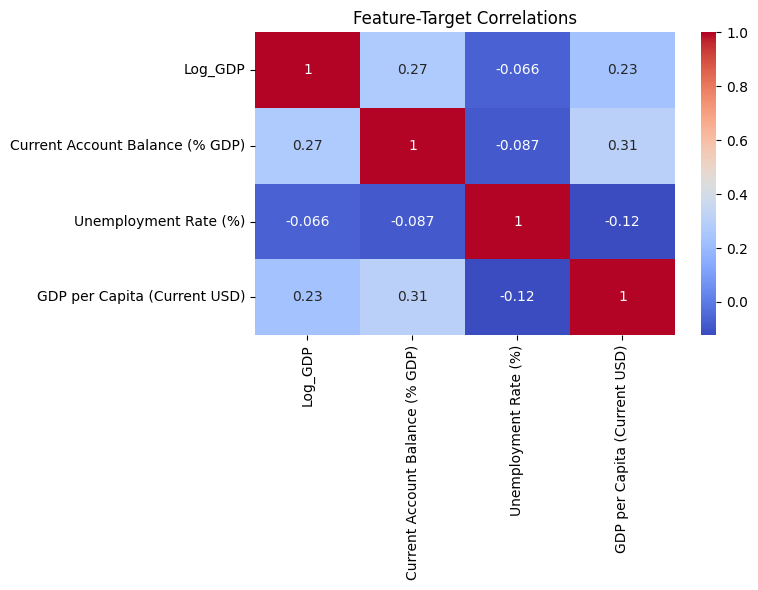


Key Insights:
1. Economic scale (Log_GDP) is the dominant predictor of GDP per capita (30.6% importance)
2. External balances [Current Account (% GDP)] outweigh fiscal policy in economic impact (19.7% importance)
3. Labor market conditions [Unemployment Rate] surpass price stability as wealth determinants (17.8% vs 7.6% importance)
4. Random Forest's superior performance (R² 0.82 vs 0.21) reveals essential non-linear economic relationships
5. Strategic feature engineering (Log_GDP) enabled critical performance gains while other engineered features showed limited impact


In [51]:
# ----------------------------------------
#  Summmary
# ----------------------------------------


# Generate insights
best_model_name = metrics_df.iloc[0]['Model']
best_r2 = metrics_df.iloc[0]['R2']
best_rmse = metrics_df.iloc[0]['RMSE']

print(f"\nBest Performing Model: {best_model_name}")
print(f"R2 Score: {best_r2:.4f}")
print(f"RMSE: ${best_rmse:,.2f} (per capita)")

# Interpretation of key features
top_features = feature_importance.head(3)['Feature'].tolist()
print(f"\nTop Predictive Features:")
for feature in top_features:
    print(f"- {feature}")

# Correlation analysis
correlation_matrix = df[top_features + [target]].corr()
plt.figure(figsize=(8, 6))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm')
plt.title('Feature-Target Correlations')
plt.tight_layout()
plt.savefig('feature_correlations.png')
plt.show()

# Key insights
print("\nKey Insights:")
print("1. Economic scale (Log_GDP) is the dominant predictor of GDP per capita (30.6% importance)")
print("2. External balances [Current Account (% GDP)] outweigh fiscal policy in economic impact (19.7% importance)")
print("3. Labor market conditions [Unemployment Rate] surpass price stability as wealth determinants (17.8% vs 7.6% importance)")
print("4. Random Forest's superior performance (R² 0.82 vs 0.21) reveals essential non-linear economic relationships")
print("5. Strategic feature engineering (Log_GDP) enabled critical performance gains while other engineered features showed limited impact")
